In [35]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [36]:
# MNIST 데이터셋 다운로드 (1분 가량 소요)
mnist = datasets.fetch_openml('mnist_784', version=1)

In [37]:
X, y = mnist.data, mnist.target
y = y.apply(int)

# 데이터 분할 및 스케일링
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((56000, 784), (14000, 784), (56000,), (14000,))

In [38]:
# 이진 분류용 훈련 데이터 준비
def prepare_binary_classification_data(X, y, label1, label2):
    binary_index = (y == label1) | (y == label2)
    X_binary = X[binary_index]
    y_binary = y[binary_index]
    y_map = {label1: -1, label2: 1}
    y_binary = np.array([y_map[label] for label in y_binary])
    return X_binary, y_binary

X_train_binary, y_train_binary = prepare_binary_classification_data(X_train, y_train, 3, 5)
X_test_binary, y_test_binary = prepare_binary_classification_data(X_test, y_test, 3, 5)

X_train_binary.shape, X_test_binary.shape, y_train_binary.shape, y_test_binary.shape

((10763, 784), (2691, 784), (10763,), (2691,))

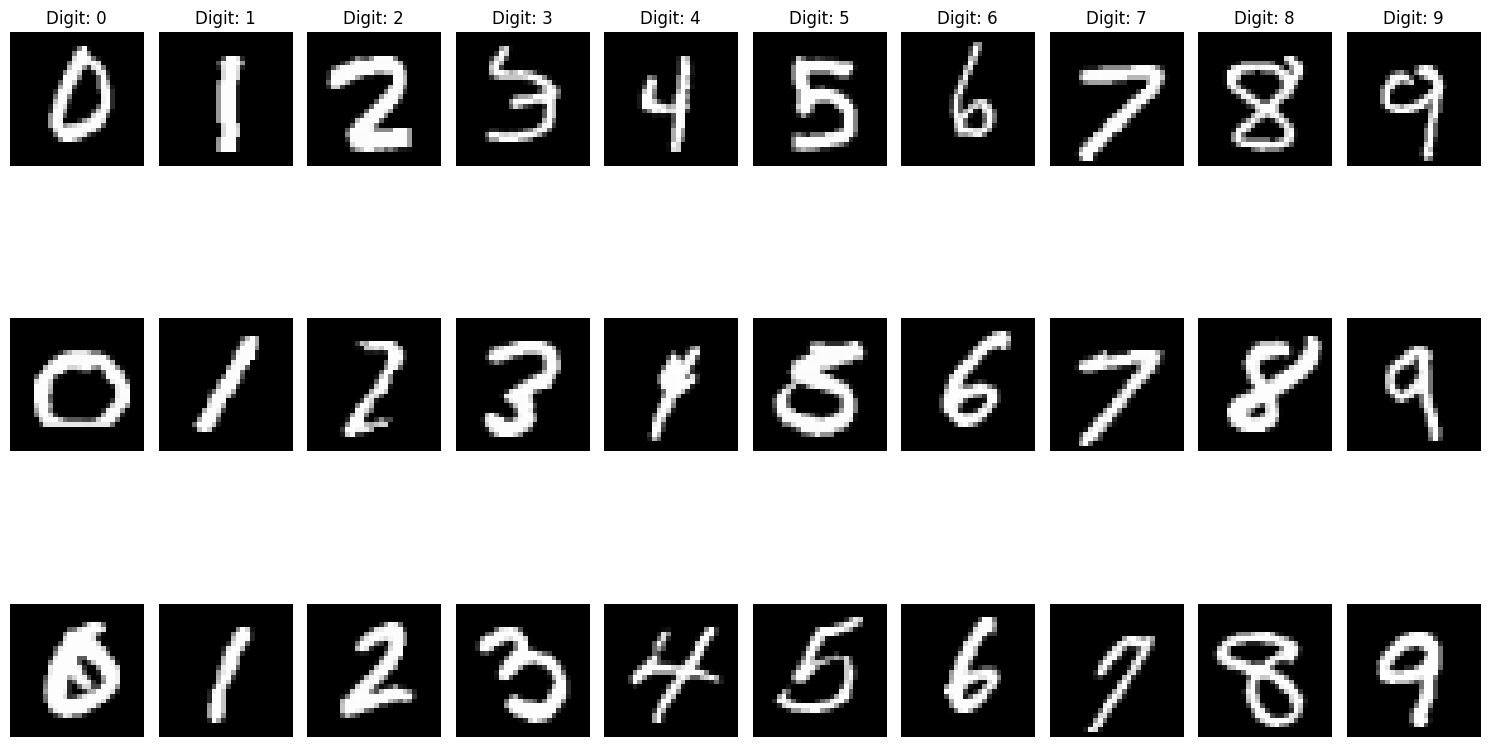

In [39]:
# 데이터 시각화
n_classes = 10
n_samples_per_class = 3
samples_per_class = {i: [] for i in range(n_classes)}

for digit in range(n_classes):
    digit_indices = np.where(y == digit)[0]
    selected_indices = np.random.choice(digit_indices, n_samples_per_class, replace=False)
    samples_per_class[digit] = selected_indices

plt.figure(figsize=(15, 10))
for digit in range(n_classes):
    for i in range(n_samples_per_class):
        idx = samples_per_class[digit][i]

        plt.subplot(n_samples_per_class, n_classes, i * n_classes + digit + 1)
        plt.imshow(X.iloc[idx].values.reshape(28, 28), cmap='gray')
        if i == 0:
            plt.title(f"Digit: {digit}")
        plt.axis('off')

plt.tight_layout()
plt.show()

## 1. SVM from scratch

fit 함수의 가중치 업데이트 부분을 채워주세요! 가중치 업데이트 이외의 코드는 수정하면 안됩니다.

조건: 분류 정확도 0.9 이상

참고자료: https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47

In [40]:
class SVMClassifier:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        # 이 부분은 수정하시면 안됩니다.
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None
        self.label_map = None
        self.inverse_label_map = None

    def fit(self, X, y):
        # 이 부분은 수정하시면 안됩니다.
        unique_labels = np.unique(y)
        if len(unique_labels) != 2:
            raise ValueError("This SVM implementation supports only binary classification.")

        self.label_map = {unique_labels[0]: -1, unique_labels[1]: 1}
        self.inverse_label_map = {-1: unique_labels[0], 1: unique_labels[1]}

        y_ = np.array([self.label_map[label] for label in y])

        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):

                condition = y_[idx] * (np.dot(x_i, self.w) + self.b) >= 1 # 각 데이터 포인트가 서포트 벡터의 마진 범위 밖에 존재하는지 확인

                if condition: # 데이터 포인트가 마진 범위 밖에 존재
                    self.w -= self.learning_rate * (2 * self.lambda_param * self.w)

                else: # 데이터 포인트가 마진 범위 안에 존재(misclassification)
                    self.w -= self.learning_rate * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx])) # 데이터 포인트가 마진 내에 존재하므로 해당 데이터를 마진 밖으로 이동시키기 위해 np.dot(x_i, y_[idx])를 패널티로 사용
                    self.b += self.learning_rate * y_[idx] # 마찬가지로 데이터를 마진 밖으로 이동시키기 위해 바이어스를 조정하여 결정 경계 이동


    def predict(self, X):

        predictions=[]

        for x_i in X:

            predicted_label = np.sign(np.dot(x_i, self.w) + self.b)  # -1과 1로 분류되는 라벨
            original_label = self.inverse_label_map[predicted_label]  # 원래 라벨로 변환
            predictions.append(original_label)

            # np.sign(): 데이터가 양수이면 1, 음수이면 -1을 반환하여 이진 레이블로 분류할 수 있도록 함
            # self.inverse_label_map[predict_label]: predict한 레이블의 본래 값을 반환하여 모델의 정확성을 평가할 수 있도록 함

        return np.array(predictions)

In [41]:
svm = SVMClassifier()

fit_start = time.time()
svm.fit(X_train_binary, y_train_binary)
fit_end = time.time()

pred_start = time.time()
pred = svm.predict(X_test_binary)
pred_end = time.time()

print(f"Accuracy: {accuracy_score(y_test_binary, pred)}")
print(f"Fitting time: {fit_end - fit_start} seconds")
print(f"Prediction Time: {pred_end - pred_start} seconds")

Accuracy: 0.9602378298030472
Fitting time: 96.91500949859619 seconds
Prediction Time: 0.014085769653320312 seconds


## 2. Dimensionality Reduction

PCA와 LDA를 활용하여 데이터 차원을 축소한 뒤, 모델 학습을 진행해주세요!

PCA 적용하기

In [42]:
from sklearn.decomposition import PCA

# PCA를 사용하여 X_train_binary의 차원을 축소해주세요.

pca = PCA(n_components=0.95) # 분산 비율의 누적합이 95%가 될 때까지 주성분 선택
X_train_pca = pca.fit_transform(X_train_binary) # PCA를 적용하여 X값 축소
X_test_pca = pca.transform(X_test_binary) # PCA를 적용하여 Y값 축소

print(X_train_pca.shape, X_test_pca.shape)

svm = SVMClassifier()
fit_start = time.time()
svm.fit(X_train_pca, y_train_binary)
fit_end = time.time()

pred_start = time.time()
pred = svm.predict(X_test_pca)
pred_end = time.time()

print(f"Accuracy: {accuracy_score(y_test_binary, pred)}")
print(f"Fitting time: {fit_end - fit_start} seconds")
print(f"Prediction Time: {pred_end - pred_start} seconds")

(10763, 201) (2691, 201)
Accuracy: 0.956893348197696
Fitting time: 90.2746684551239 seconds
Prediction Time: 0.013377189636230469 seconds


LDA 적용하기

In [43]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=1) # 이진 분류라 클래스가 2개이므로 n_component를 1로 설정(class-1)
X_train_lda = lda.fit_transform(X_train_binary, y_train_binary)
X_test_lda = lda.transform(X_test_binary)

print(X_train_lda.shape, X_test_lda.shape)

svm = SVMClassifier()
fit_start = time.time()
svm.fit(X_train_lda, y_train_binary)
fit_end = time.time()

pred_start = time.time()
pred = svm.predict(X_test_lda)
pred_end = time.time()

print(f"Accuracy: {accuracy_score(y_test_binary, pred)}")
print(f"Fitting time: {fit_end - fit_start} seconds")
print(f"Prediction Time: {pred_end - pred_start} seconds")

(10763, 1) (2691, 1)
Accuracy: 0.94611668524712
Fitting time: 101.95172762870789 seconds
Prediction Time: 0.006693601608276367 seconds


## 3. Multiclass SVM

OvO (One vs One) 방법론을 사용하여 Multiclass svm classifier를 구현해주세요!

In [44]:
# 학습 효율성을 위해 데이터셋의 일부만 사용
mnist_df = pd.concat([mnist.data, mnist.target], axis=1)
mnist_df = mnist_df.groupby('class').apply(lambda x: x.sample(frac=0.01, random_state=42)).reset_index(drop=True)

X, y = mnist_df.drop('class', axis=1), mnist_df['class']
y = y.apply(int)

# 데이터 분할 및 스케일링
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((560, 784), (140, 784), (560,), (140,))

In [45]:
y_train.unique()

[9, 6, 1, 3, 7, 5, 8, 2, 4, 0]
Categories (10, int64): [0, 1, 2, 3, ..., 6, 7, 8, 9]

In [51]:
'''
위 데이터 (X_train, X_test, y_train, y_test)와 앞서 구현한 SVMClassifier를 사용하여 다중 클래스 분류를 수행해주세요.

사이킷런 및 각종 패키지에서 제공하는 svm 모델은 사용하실 수 없습니다.

'''

def prepare_binary_classification_data_ovo(X, y, label1, label2):

    # 본래 함수가 라벨을 -1과 1로 바꿔버리므로 이 과정을 생략하도록 만든 새로운 함수

    binary_index = (y == label1) | (y == label2)
    X_binary = X[binary_index]
    y_binary = y[binary_index]
    return X_binary, y_binary



class OVOSVMClassifier:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.classifiers = {}

    def fit(self, X, y):

        self.unique_labels = np.unique(y)


        for i, label1 in enumerate(self.unique_labels):
            for label2 in self.unique_labels[i + 1:]:

                # 이진 분류용 데이터 준비
                X_binary, y_binary = prepare_binary_classification_data_ovo(X, y, label1, label2)


                clf = SVMClassifier(self.learning_rate, self.lambda_param, self.n_iters)



                clf.fit(X_binary, y_binary)

                self.classifiers[(label1, label2)] = clf




    def predict(self, X):

        predictions = np.zeros((X.shape[0], len(self.classifiers)))

        for idx, ((label1, label2), tm) in enumerate(self.classifiers.items()):

            prediction = tm.predict(X)


            #각 분류기의 예측 결과를 저장

            predictions[:, idx] = np.where(prediction == label1, label1, label2)


        final_predictions = []


        for i in predictions:

            # 각 샘플에 대해 가장 많이 예측된 클래스를 선택
            unique, counts = np.unique(i, return_counts=True)
            final_predictions.append(unique[np.argmax(counts)])


        return np.array(final_predictions)

In [52]:
ovo = OVOSVMClassifier()

fit_start = time.time()
ovo.fit(X_train, y_train)
fit_end = time.time()

pred_start = time.time()
pred = ovo.predict(X_test)
pred_end = time.time()

print(f"Accuracy: {accuracy_score(y_test, pred)}")
print(f"Fitting time: {fit_end - fit_start} seconds")
print(f"Prediction Time: {pred_end - pred_start} seconds")

Accuracy: 0.85
Fitting time: 39.444525718688965 seconds
Prediction Time: 0.025670289993286133 seconds
